# Analysis of the pretrained facenet

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import sklearn
import scipy
import seaborn as sns

In [2]:
import tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
tqdm.pandas()

In [3]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [4]:
#from pandarallel import pandarallel
#pandarallel.initialize(progress_bar=True)

In [5]:
#import itables
#from itables import show

In [6]:
from collections import namedtuple
import itertools
from itertools import product

In [7]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [8]:
import PIL as pil
from PIL import Image, ImageDraw

In [9]:
#import papermill as pm

In [10]:
import math

In [11]:
import matplotlib
matplotlib.rcParams["image.origin"] = 'upper'

In [12]:
import sys
import os

In [13]:
import functools

In [14]:
import tensorflow as tf

In [15]:
import torch
import torchvision

In [16]:
from einops import *

In [17]:
import cv2

In [18]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [19]:
import networkx as nx

In [20]:
from pathlib import Path

## Load in the pretrained facenet

In [21]:
import model
from model import face_model

In [22]:
import importlib
model = importlib.reload(model)
face_model = model.face_model

In [23]:
class Params():
    def __init__(self):
        self.image_size = 250
        self.embedding_size=128

In [24]:
fm = face_model(Params())

In [25]:
checkpoint = tf.train.Checkpoint(fm)

In [26]:
checkpoint.restore('../weights/weights/ckpt/ckpt-11')

In [27]:
#!mkdir saved_model
#fm.save('saved_model/my_model')

In [28]:
#import onnx
#from onnx2torch import convert
#onnx_model_path = 'model.onnx'
#onnx_model = onnx.load(onnx_model_path)
#torch_model_1 = convert(onnx_model)

## Load in our Casuarina images

In [29]:
ROOT_DIR = Path(r'E:\FRDC-ML\src\frdc\conf.py').parents[2]
LOCAL_DATASET_ROOT_DIR = ROOT_DIR / 'rsc'
LOCAL_BACKEND_DATA_ROOT_DIR = ROOT_DIR / 'backend-rsc'
SECRETS_DIR = ROOT_DIR / '.secrets'
GCS_PROJECT_ID = 'frmodel'
GCS_BUCKET_NAME = 'frdc-scan'
GCS_BACKEND_BUCKET_NAME = 'files-from-backend'

In [30]:
LOCAL_DATASET_ROOT_DIR

WindowsPath('E:/FRDC-ML/rsc')

In [31]:
sys.path.append('E:\FRDC-ML\src')

In [32]:
import frdc
import frdc.load
import frdc.conf

In [33]:
bands = dict(BLUE=frdc.conf.Band.BLUE,
             GREEN=frdc.conf.Band.GREEN,
             RED=frdc.conf.Band.RED,
             RED_EDGE=frdc.conf.Band.RED_EDGE,
             NIR=frdc.conf.Band.NIR)
band_names = ['blue', 'green', 'red', 'red_edge', 'nir']

In [34]:
ds_93deg =\
frdc.load.FRDCDataset('casuarina', '20220418', '93deg',
                      dl=frdc.load.FRDCDownloader(local_dataset_root_dir=LOCAL_DATASET_ROOT_DIR))

E:\miniconda3\envs\work_env\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [35]:
ar_93deg = ds_93deg.get_ar_bands()

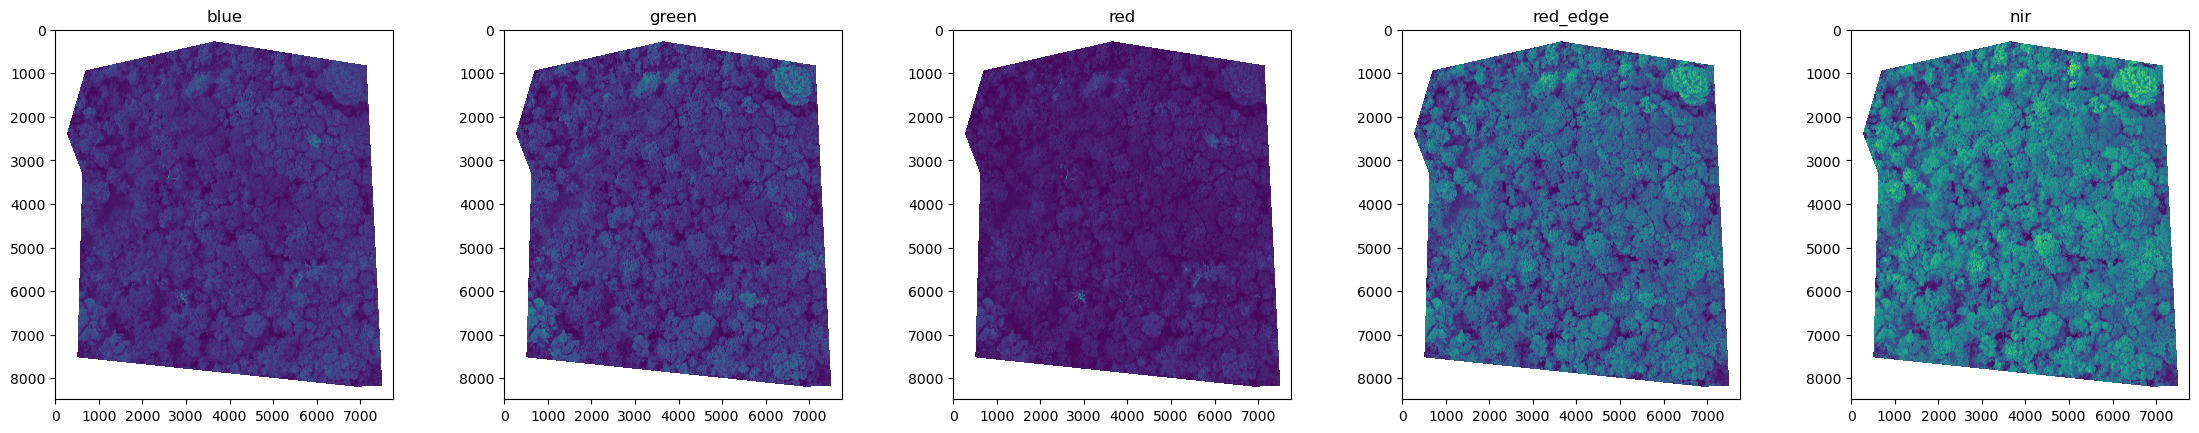

In [36]:
fig, ax = plt.subplots(1, ncols:=ar_93deg.shape[-1], figsize=(5.6*ncols, 4.8))
for box, idx in zip(ax, range(ncols)):
    box.imshow(ar_93deg[:,:,idx])
    box.set_title(band_names[idx])

In [37]:
ds_183deg =\
frdc.load.FRDCDataset('casuarina', '20220418', '183deg',
                      dl=frdc.load.FRDCDownloader(local_dataset_root_dir=LOCAL_DATASET_ROOT_DIR))

In [38]:
ar_183deg = ds_183deg.get_ar_bands()

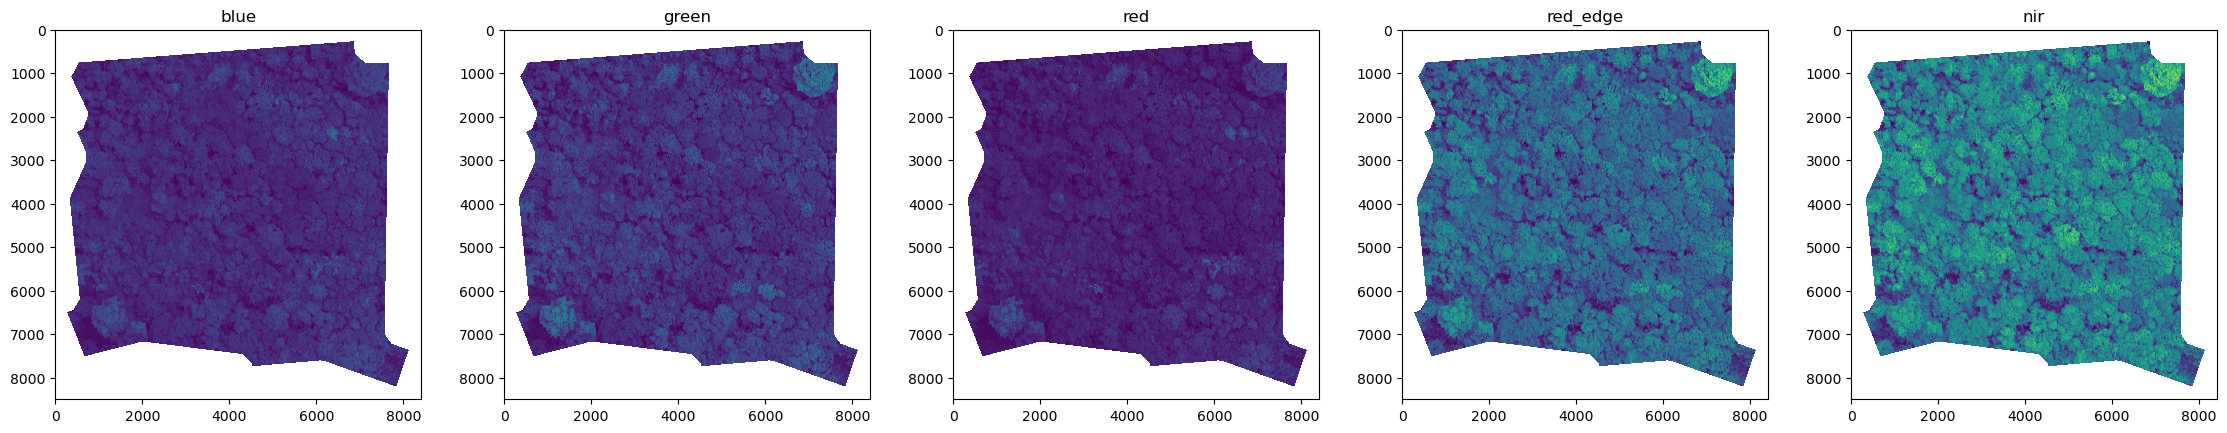

In [39]:
fig, ax = plt.subplots(1, ncols:=ar_183deg.shape[-1], figsize=(5.6*ncols, 4.8))
for box, idx in zip(ax, range(ncols)):
    box.imshow(ar_183deg[:,:,idx])
    box.set_title(band_names[idx])

## Load in our Chestnut images

In [40]:
ds_december =\
frdc.load.FRDCDataset('chestnut_nature_park', '20201218', None,
                      dl=frdc.load.FRDCDownloader(local_dataset_root_dir=LOCAL_DATASET_ROOT_DIR))

In [41]:
ar_december = ds_december.get_ar_bands()

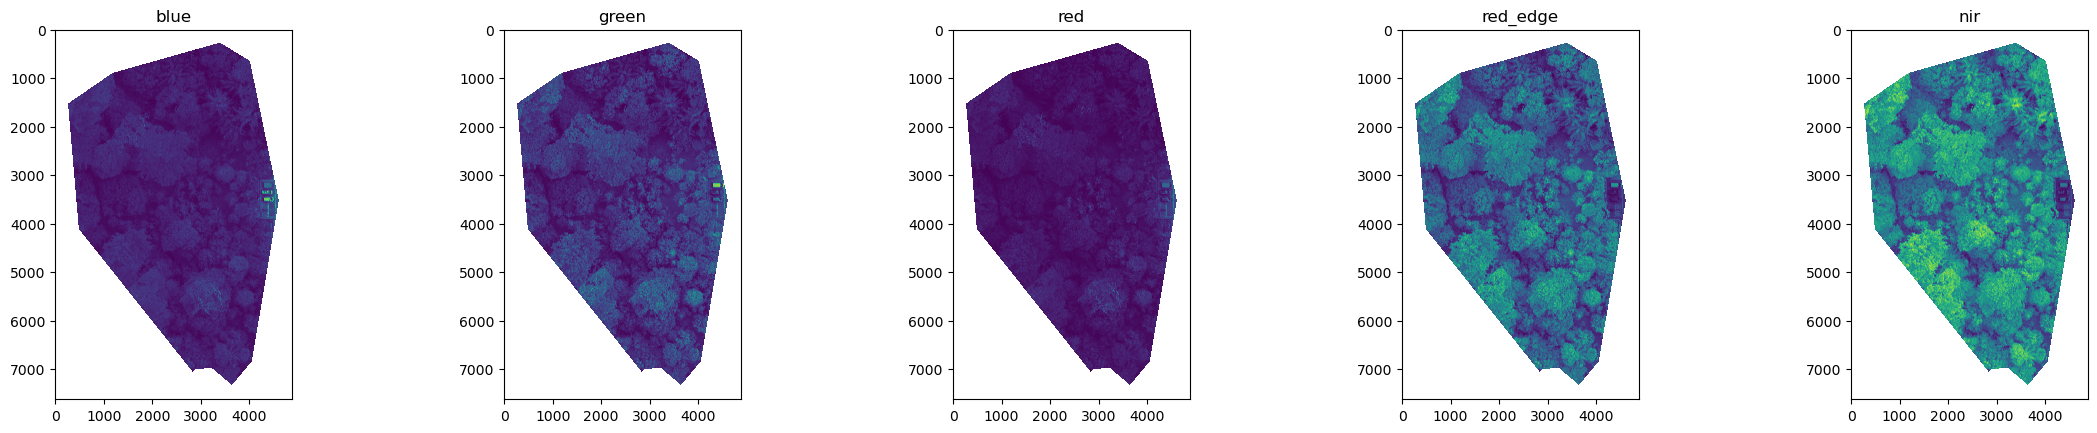

In [42]:
fig, ax = plt.subplots(1, ncols:=ar_december.shape[-1], figsize=(5.6*ncols, 4.8))
for box, idx in zip(ax, range(ncols)):
    box.imshow(ar_december[:,:,idx])
    box.set_title(band_names[idx])

In [43]:
ds_may =\
frdc.load.FRDCDataset('chestnut_nature_park', '20210510', '90deg43m85pct255deg/map',
                      dl=frdc.load.FRDCDownloader(local_dataset_root_dir=LOCAL_DATASET_ROOT_DIR))

In [44]:
ar_may = ds_may.get_ar_bands()

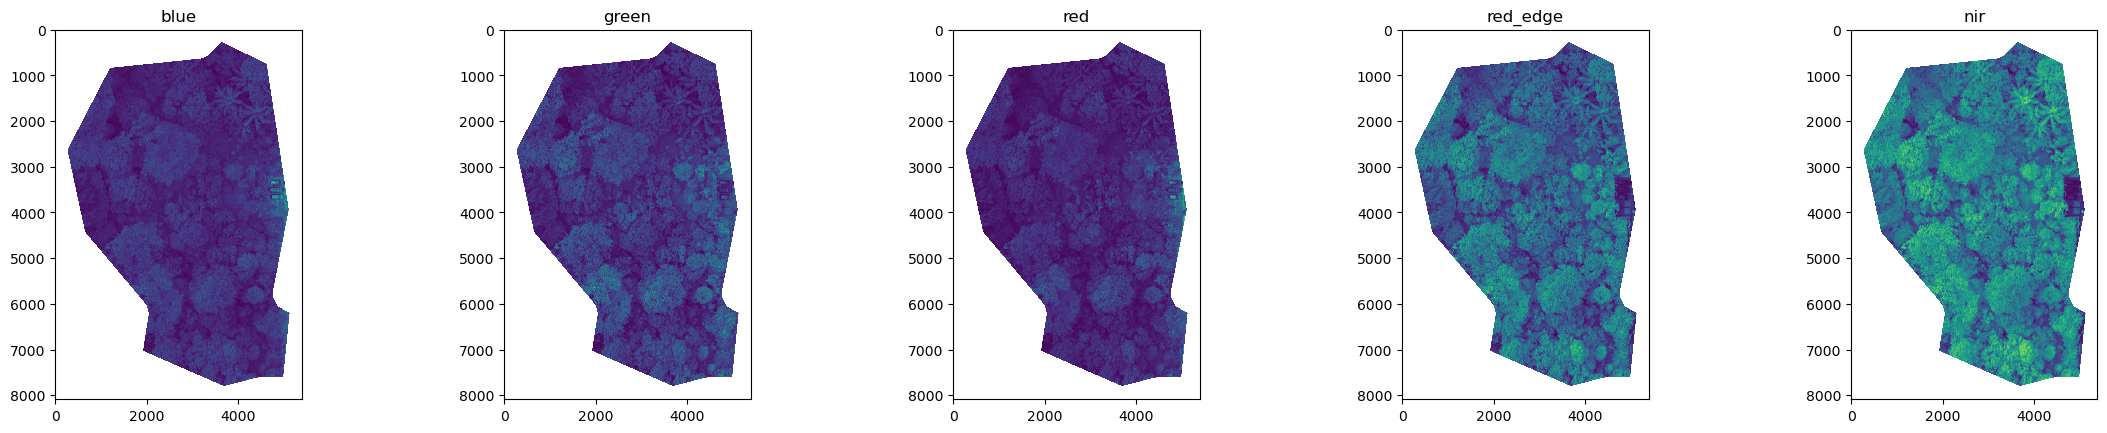

In [45]:
fig, ax = plt.subplots(1, ncols:=ar_may.shape[-1], figsize=(5.6*ncols, 4.8))
for box, idx in zip(ax, range(ncols)):
    box.imshow(ar_may[:,:,idx])
    box.set_title(band_names[idx])

## Load in our Chestnut dataframe

In [46]:
df_chestnut = pd.read_pickle('df_augment.pickle')

In [47]:
df_chestnut = df_chestnut.reset_index()

In [48]:
df_chestnut.columns

Index(['index', 'npz_path', 'path_str_split', 'phase', 'filename', 'species',
       'tree_id', 'glcm', 'sel_features', 'pre_pca_augment',
       'pre_pca_augment_embeddings'],
      dtype='object')

In [49]:
bands_chestnut = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi']
bands_sel = ['re', 'b', 'nir', 'r', 'g']
props_chestnut = ['mean_no_glcm', 'mean', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [50]:
df_chestnut.shape

(1320, 11)

In [51]:
df_chestnut['sel_features'].iloc[0].shape

(238, 266, 10)

In [52]:
df_chestnut['glcm'].iloc[0].shape

(238, 266, 8, 7)

In [53]:
df_chestnut_unaug = df_chestnut.drop_duplicates('index')

## How do the histograms for May, December, 93deg and 183deg differ?

In [54]:
df_tifs = pd.DataFrame(['ar_93deg', 'ar_183deg', 'ar_may', 'ar_december'], columns=['arr_name'])

In [55]:
df_tifs['arr'] = None
df_tifs['arr'] = df_tifs['arr'].astype('object')
df_tifs = df_tifs.copy()

In [56]:
df_tifs.loc[0]['arr'] = ar_93deg
df_tifs.loc[1]['arr'] = ar_183deg
df_tifs.loc[2]['arr'] = ar_may
df_tifs.loc[3]['arr'] = ar_december

In [57]:
df_tifs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   arr_name  4 non-null      object
 1   arr       4 non-null      object
dtypes: object(2)
memory usage: 196.0+ bytes


In [67]:
for band in band_names:
    df_tifs[band] = df_tifs['arr'].progress_apply(lambda x: x[:,:,band_names.index(band)].flatten())

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [68]:
for band in band_names:
    df_tifs[band] = df_tifs[band].apply(lambda x: [x[np.random.randint(len(x))] for i in tqdm(range(20_000))])

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [90]:
df_px_vals = df_tifs[['arr_name'] + band_names].explode(band_names)

In [92]:
df_px_vals = pd.melt(df_px_vals, id_vars=['arr_name'], ignore_index=False)

In [93]:
df_px_vals = df_px_vals.dropna()

In [94]:
df_px_vals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265837 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   arr_name  265837 non-null  object
 1   variable  265837 non-null  object
 2   value     265837 non-null  object
dtypes: object(3)
memory usage: 8.1+ MB


In [95]:
gc.collect()

2015

E:\miniconda3\envs\work_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\miniconda3\envs\work_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\miniconda3\envs\work_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\miniconda3\envs\work_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

<Axes: xlabel='value', ylabel='Count'>

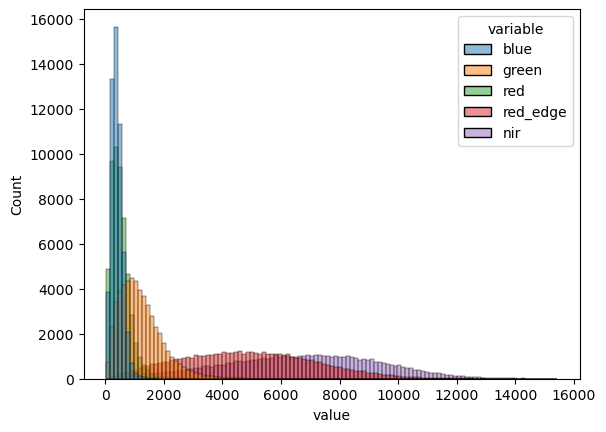

In [96]:
sns.histplot(df_px_vals.reset_index(), x='value', hue='variable')

In [97]:
arr_names = df_px_vals['arr_name'].unique()

In [104]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

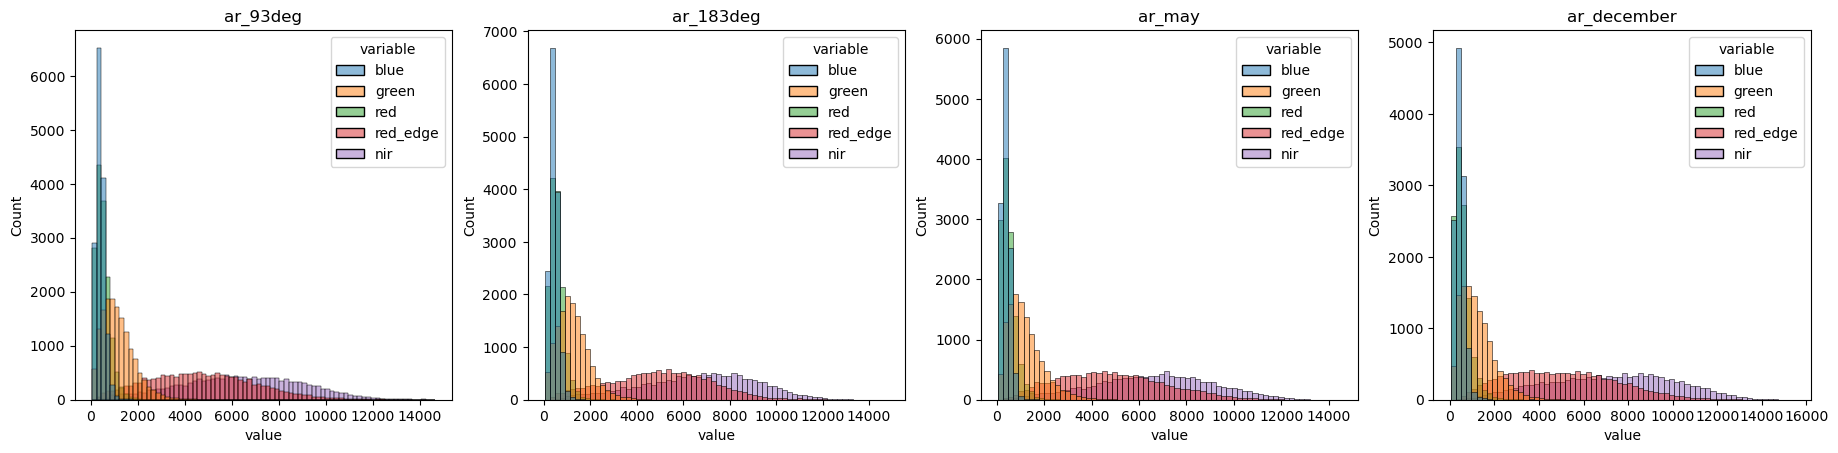

In [105]:
fig, ax = plt.subplots(1, ncols:=len(arr_names), figsize=(5.6*ncols, 4.8))
for box, arr_name in zip(ax, arr_names):
    sns.histplot(df_px_vals[df_px_vals['arr_name'] == arr_name].reset_index(),
                 x='value', hue='variable',
                 ax=box)
    box.set_title(arr_name)

## Discard our Chestnut images

In [ ]:
del ds_93deg, ar_93deg
del ds_183deg, ar_183deg
del ds_may, ar_may
del ds_december, ar_december

In [ ]:
gc.collect()

In [ ]:
del df_tifs
del df_px_vals

In [ ]:
gc.collect()